<a href="https://colab.research.google.com/github/ShreyaShankar2004/shreya/blob/main/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -q kaggle tensorflow tensorflow-addons

# Upload your kaggle.json
from google.colab import files
files.upload()

# Configure Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d kmader/parkinsons-drawings
!unzip -q parkinsons-drawings.zip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 30.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/parkinsons-drawings
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)


In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

def load_dataset(base_path, label_map):
    image_paths, labels = [], []
    for label in os.listdir(base_path):
        if label not in label_map:
            continue
        for fname in os.listdir(os.path.join(base_path, label)):
            fpath = os.path.join(base_path, label, fname)
            image_paths.append(fpath)
            labels.append(label_map[label])
    return image_paths, labels

# Define label mapping
label_map = {"healthy": 0, "parkinson": 1}

# Use spiral drawings for this experiment
train_paths, train_labels = load_dataset("drawings/spiral/training", label_map)
test_paths, test_labels = load_dataset("drawings/spiral/testing", label_map)

# Resize to 224x224 for EfficientNet
def preprocess_images_rgb(image_paths, img_size=224):
    data = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0
        data.append(img)
    return np.array(data)

X_train = preprocess_images_rgb(train_paths)
X_test = preprocess_images_rgb(test_paths)
y_train = np.array(train_labels)
y_test = np.array(test_labels)


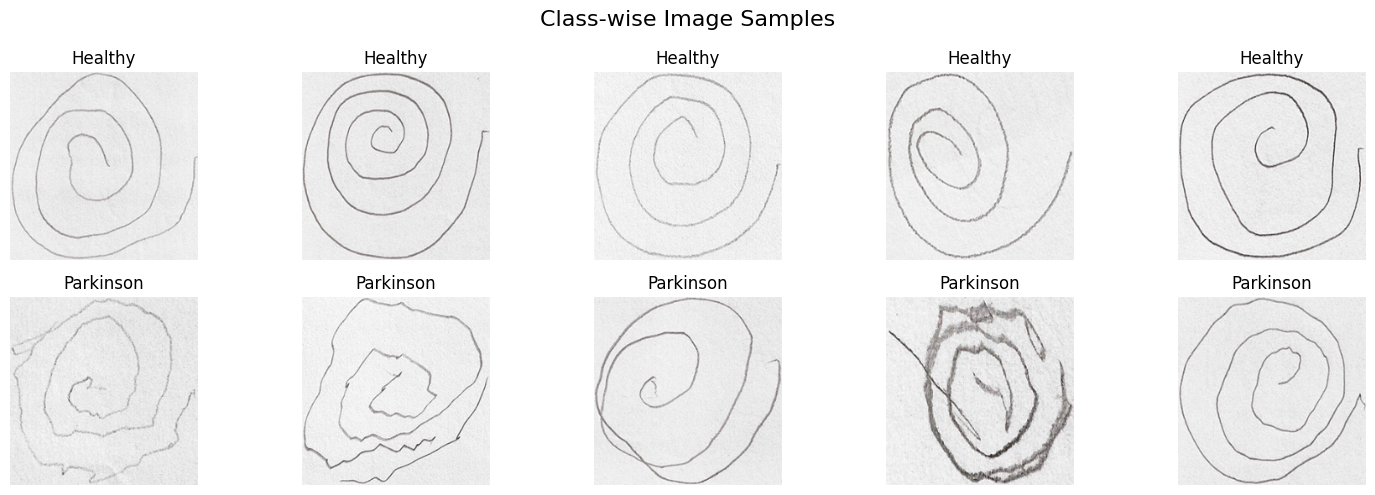

In [6]:
def show_classwise_samples(X, y, n=5):
    plt.figure(figsize=(15, 5))
    healthy = X[y == 0][:n]
    parkinson = X[y == 1][:n]

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(healthy[i])
        plt.title("Healthy")
        plt.axis("off")

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(parkinson[i])
        plt.title("Parkinson")
        plt.axis("off")

    plt.suptitle("Class-wise Image Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

show_classwise_samples(X_train, y_train)


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

def build_model(input_shape=(224, 224, 3)):
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Fine-tune some layers
    base_model.trainable = True
    for layer in base_model.layers[:200]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-5),
                  loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,989,104 (41.92 MB)

 Trainable params: 10,027,151 (38.25 MB)

 Non-trainable params: 961,953 (3.67 MB)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

train_gen = aug.flow(X_train, y_train, batch_size=32)

history = model.fit(
    train_gen,
    validation_data=(X_test, y_test),
    epochs=20
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 136s 25s/step - accuracy: 0.4866 - loss: 1.1075 - val_accuracy: 0.5000 - val_loss: 0.7281
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step - accuracy: 0.4790 - loss: 1.2167 - val_accuracy: 0.5000 - val_loss: 0.7247
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step - accuracy: 0.5910 - loss: 0.8918 - val_accuracy: 0.5000 - val_loss: 0.7215
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 449ms/step - accuracy: 0.4299 - loss: 1.1733 - val_accuracy: 0.5000 - val_loss: 0.7184
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - accuracy: 0.4609 - loss: 0.9342 - val_accuracy: 0.5000 - val_loss: 0.7161
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - accuracy: 0.4378 - loss: 1.2514 - val_accuracy: 0.5000 - val_loss: 0.7139
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step - accuracy: 0.4450 - loss: 1.1476 - val_accuracy: 0.5000 - val_loss: 0.7125
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.5994 - loss: 1.0478 - val_accuracy: 0.5000 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        15
   Parkinson       0.50      1.00      0.67        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


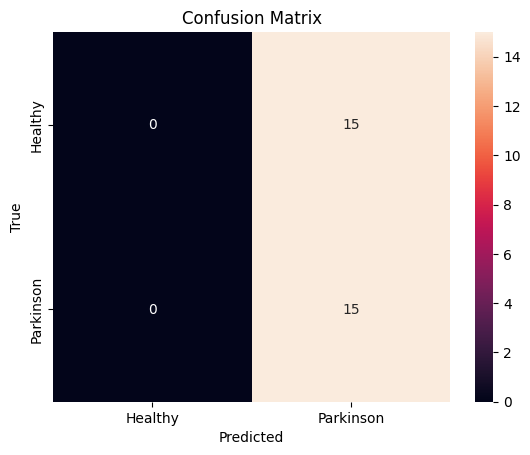

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Report
print(classification_report(y_test, y_pred, target_names=["Healthy", "Parkinson"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Healthy", "Parkinson"], yticklabels=["Healthy", "Parkinson"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
